In [27]:
import pickle
import pandas as pd
import numpy as np

In [28]:
df = pd.read_pickle('turbine1_df_final.pkl')



In [29]:
df['# Date and time'] = pd.to_datetime(df['# Date and time'])
# Perform cyclic encoding for month and hour
df['month_sin'] = np.sin(2 * np.pi * df['# Date and time'].dt.month / 12)
df['month_cos'] = np.cos(2 * np.pi * df['# Date and time'].dt.month / 12)

df['hour_sin'] = np.sin(2 * np.pi * df['# Date and time'].dt.hour / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['# Date and time'].dt.hour / 24)

# Drop the original 'Date and time' column
df.drop('# Date and time', axis=1, inplace=True)

In [30]:
from sklearn.model_selection import train_test_split

# Split the dataset into training, validation, and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=False)
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42, shuffle=False)

# Print the shape of each split
print('Training set shape:', train_df.shape)
print('Validation set shape:', val_df.shape)
print('Testing set shape:', test_df.shape)
test_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)

Training set shape: (78436, 66)
Validation set shape: (26146, 66)
Testing set shape: (26146, 66)


In [31]:
!pip install pytorch-tabnet
from pytorch_tabnet.tab_model import TabNetRegressor
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

import pandas as pd
import numpy as np
np.random.seed(0)


import os


In [32]:
train_indices = train_df.index
valid_indices = val_df.index
test_indices = test_df.index
print(valid_indices)

RangeIndex(start=0, stop=26146, step=1)


In [33]:
target = 'Power (kW)'
features = [ col for col in train_df.columns if col not in target] 

X_train = train_df[features].values[train_indices]
y_train = train_df[target].values[train_indices].reshape(-1, 1)

X_valid = val_df[features].values[valid_indices]
y_valid = val_df[target].values[valid_indices].reshape(-1, 1)

X_test = test_df[features].values[test_indices]
y_test = test_df[target].values[test_indices].reshape(-1, 1)


In [34]:
max_epochs = 40 if not os.getenv("CI", False) else 2

In [35]:
from pytorch_tabnet.augmentations import RegressionSMOTE
aug = RegressionSMOTE(p=0.2)


In [25]:

clf = TabNetRegressor(n_d=8, n_a=8, n_steps=16 ,gamma=1.95)


c:\Users\rachitgandhi1\AppData\Local\anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [26]:
clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=['rmsle', 'mae', 'rmse', 'mse'],
    max_epochs=max_epochs,
    patience=50,
    batch_size=1024, virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
    augmentations=aug, #aug
) 

epoch 0  | loss: 1.76904 | train_rmsle: 0.18202 | train_mae: 0.21117 | train_rmse: 0.25996 | train_mse: 0.06758 | valid_rmsle: 0.16384 | valid_mae: 0.185   | valid_rmse: 0.22626 | valid_mse: 0.05119 |  0:01:12s
epoch 1  | loss: 0.13267 | train_rmsle: 0.13949 | train_mae: 0.14952 | train_rmse: 0.21941 | train_mse: 0.04814 | valid_rmsle: 0.12634 | valid_mae: 0.13337 | valid_rmse: 0.19433 | valid_mse: 0.03776 |  0:02:48s
epoch 2  | loss: 0.02175 | train_rmsle: 0.13933 | train_mae: 0.14596 | train_rmse: 0.22098 | train_mse: 0.04883 | valid_rmsle: 0.1299  | valid_mae: 0.13479 | valid_rmse: 0.20061 | valid_mse: 0.04024 |  0:04:25s
epoch 3  | loss: 0.01553 | train_rmsle: 0.09007 | train_mae: 0.09885 | train_rmse: 0.14113 | train_mse: 0.01992 | valid_rmsle: 0.08639 | valid_mae: 0.09414 | valid_rmse: 0.12971 | valid_mse: 0.01682 |  0:05:59s
epoch 4  | loss: 0.01232 | train_rmsle: 0.07845 | train_mae: 0.08565 | train_rmse: 0.1213  | train_mse: 0.01471 | valid_rmsle: 0.07721 | valid_mae: 0.08175 

KeyboardInterrupt: 

In [ ]:
preds = clf.predict(X_test)

y_true = y_test
print(preds)
test_score = mean_squared_error(y_pred=preds, y_true=y_true)


In [ ]:
print(y_true)

In [16]:
print(test_score)

0.001333700082824566


In [17]:
clf.feature_importances_

array([0.00000000e+00, 5.11124114e-03, 3.80652580e-04, 0.00000000e+00,
       3.31431688e-04, 0.00000000e+00, 4.45754137e-01, 4.31947773e-06,
       1.70431749e-04, 8.02985657e-05, 3.72400595e-02, 1.87241533e-03,
       0.00000000e+00, 1.36163448e-02, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 9.37330384e-06, 1.19780351e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.03806236e-06, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.70625119e-07, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 4.69831362e-02, 3.48946452e-05, 0.00000000e+00,
       0.00000000e+00, 1.61254035e-04, 3.79030200e-06, 1.15724141e-02,
       1.47628134e-02, 3.44903127e-05, 2.71419109e-01, 1.79096377e-06,
       0.00000000e+00, 3.52144809e-03, 6.91953969e-07, 1.38525489e-02,
       0.00000000e+00, 1.08800646e-02, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 2.85830426e-05, 0.00000000e+00, 0.00000000e+00,
      

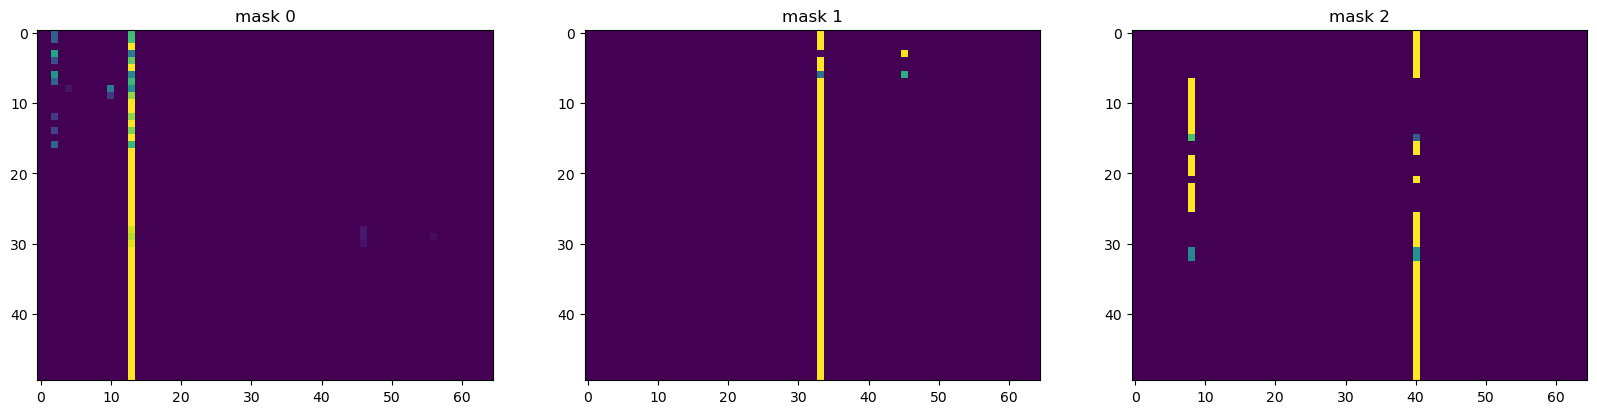

In [18]:
explain_matrix, masks = clf.explain(X_test)
from matplotlib import pyplot as plt
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")

In [21]:
from xgboost import XGBRegressor

reg_xgb = XGBRegressor(max_depth=8,
    learning_rate=0.001,
    n_estimators=1000,
    verbosity=0,
    silent=None,
    objective='reg:squarederror',
    booster='gbtree',
    n_jobs=-1,
    nthread=None,
    gamma=2,
    min_child_weight=20,
    max_delta_step=0,
    subsample=0.7,
    colsample_bytree=1,
    colsample_bylevel=1,
    colsample_bynode=1,
    reg_alpha=3,
    reg_lambda=3,
    scale_pos_weight=1,
    base_score=0.5,
    random_state=0,
    seed=None,)

reg_xgb.fit(X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        early_stopping_rounds=40,
        verbose=10)

[0]	validation_0-rmse:0.35922
[10]	validation_0-rmse:0.35569
[20]	validation_0-rmse:0.35219
[30]	validation_0-rmse:0.34872
[40]	validation_0-rmse:0.34529
[50]	validation_0-rmse:0.34190
[60]	validation_0-rmse:0.33854
[70]	validation_0-rmse:0.33521
[80]	validation_0-rmse:0.33191
[90]	validation_0-rmse:0.32864
[100]	validation_0-rmse:0.32542
[110]	validation_0-rmse:0.32221
[120]	validation_0-rmse:0.31905
[130]	validation_0-rmse:0.31592
[140]	validation_0-rmse:0.31281
[150]	validation_0-rmse:0.30974
[160]	validation_0-rmse:0.30670
[170]	validation_0-rmse:0.30369
[180]	validation_0-rmse:0.30071
[190]	validation_0-rmse:0.29776
[200]	validation_0-rmse:0.29483
[210]	validation_0-rmse:0.29194
[220]	validation_0-rmse:0.28908
[230]	validation_0-rmse:0.28624
[240]	validation_0-rmse:0.28343
[250]	validation_0-rmse:0.28065
[260]	validation_0-rmse:0.27789
[270]	validation_0-rmse:0.27517
[280]	validation_0-rmse:0.27248
[290]	validation_0-rmse:0.26980
[300]	validation_0-rmse:0.26716
[310]	validation_0-

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=2, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=0,
             max_depth=8, max_leaves=None, min_child_weight=20, missing=nan,
             monotone_constraints=None, n_estimators=1000, n_jobs=-1,
             nthread=None, num_parallel_tree=None, predictor=None, ...)

In [22]:
print(reg_xgb.feature_importances_)


[0.0933632  0.         0.         0.         0.         0.
 0.7011984  0.1938982  0.         0.         0.         0.01154026
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]


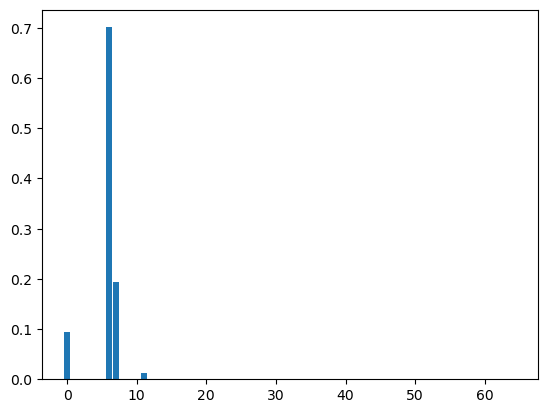

In [23]:
import matplotlib
from matplotlib import pyplot as plt

xgb_feature_importance_ = reg_xgb.feature_importances_
# plotclf_xgb.feature_importances_
plt.bar(range(len(xgb_feature_importance_)),xgb_feature_importance_)
plt.show()

In [24]:
print(reg_xgb.feature_importances_)

[0.0933632  0.         0.         0.         0.         0.
 0.7011984  0.1938982  0.         0.         0.         0.01154026
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]


In [ ]:
preds = np.array(reg_xgb.predict(X_valid))
valid_auc = mean_squared_error(y_pred=preds, y_true=y_valid)
print(valid_auc)

preds = np.array(reg_xgb.predict(X_test))
test_auc = mean_squared_error(y_pred=preds, y_true=y_test)
print(test_auc)


0.00017644276280005152
0.00014436806643773912


In [ ]:
# save tabnet model
saving_path_name = "./tabnet_model_test_1"
saved_filepath = clf.save_model(saving_path_name)

Successfully saved model at ./tabnet_model_test_1.zip


In [ ]:
# define new model with basic parameters and load state dict weights
loaded_clf = TabNetRegressor()
loaded_clf.load_model(saved_filepath)

/home/krishna/miniconda3/envs/dl/lib/python3.11/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [ ]:
loaded_preds = loaded_clf.predict(X_test)
loaded_test_mse = mean_squared_error(loaded_preds, y_test)

print(f"FINAL TEST SCORE FOR dataset : {loaded_test_mse}")


FINAL TEST SCORE FOR dataset : 0.0017761602307688475


In [ ]:
assert(test_score == loaded_test_mse)


In [ ]:
import pickle
train_df.to_pickle('train.pkl')
val_df.to_pickle('val.pkl')
test_df.to_pickle('test.pkl')